# LLM - Bielik - Fine tuning - part I

## Motivation

The rise and investments of the Large Language Models are definetely a game changer on various markets and branches - we can observe increased popularity of LLMs in academia, business and agriculture etc. Working with LLMs became a must-do task for all R&D or business departments in order to acknowledge and adapt upcoming possibilities, to stay competetive and gain business advantage. There are many players who invested bilions of USD to build their own Large Language Model and took a part in recent markets challenges by introducing their own solution trained on a different data set or to serve a different task (specialized for example in generation of poems or making a summary). At the beginning, as usual when it comes to innovation at that scale, we are thinking of endless possibilities, what kind of new opportunities we reach without putting much focus on other important factors like costs, maintanence, security, stability. Currently, we have multiple models which are production ready - many work has been done at those fields also making those LLMs more reliable and secured. One of the outcomes from this LLM race is that people noticed that it is good idea to look at smaller models, more specialized in one or two tasks, not the general ones. This specialization also is related to language supported. LLMs are broadly trained on english language data, due to the fact that more than half of websites content is written in English (source). Many models, paid and open source ones, have different level of quality when it comes when using them with local language. Quite often it occurs that offered quality is not enough to prove the business value for specific use case. This pushed some parties to create smaller models or suggested the finetuning with data in local language. 

The goal of this notebook is to finetune a Polish language based LLM called Bielik, developed by SpeakLeash organization (<model page>) with the legal / law sources. Data is specifically chosen for this task - legal documents or, law as a general concept, are strictly connected to the particular langauge. Primary concept of legal documents is to be in line with local (polish in my case) regulations. Of course, those documents can be translated to english and then used by the LLM. However, legal documents such as purchase agreements or any other agreements are designed by lawyers who understand the legal language nuances. They need to construct documents that are reliable, understandable by many (or maybe not?) and embedded in Polish law regulations. This requires from LLM to be more specific on many levels - starting from using prevalent data in one language and finetuning it to be able to work with more detailed task. 

## Introduction

This notebook covers multiple steps:
1. Loading and splitting data into chunks
2. Generating new data (question and answers) for the future finetuning
3. Evaluating generated data
4. Selecting the data based on metrics 
5. Preparing the output for FT


## Loading and splitting data

Data source: https://isap.sejm.gov.pl/isap.nsf/download.xsp/WDU20140000827/U/D20140827Lj.pdf 
ESG: https://www.gov.pl/attachment/a65956c9-880e-43bb-846e-dda0feb89370

In [1]:
import datetime
import pandas as pd
import numpy as np
from dotenv import load_dotenv, find_dotenv
import pymupdf
import uuid
from tqdm.notebook import tqdm
from langchain.text_splitter import RecursiveCharacterTextSplitter
from src.external_requests.openai_req import OpenAIReq
from src.external_requests.prompting import PromptBuilder
from src.evaluation.distance_based import DistanceEvaluator
from src.preprocessing.preprocess import remove_stopwords, clean_text
from src.evaluation.reporting import Reporting
import seaborn as sns
import tiktoken

In [2]:
_ = load_dotenv(find_dotenv())

In [3]:
splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=120)

In [4]:
# path = 'data/ustawa_nr_1.pdf'
path = 'data/dyrektywa_CSRD.pdf'

all_data = pymupdf.open(path)

In [5]:
all_chunks = []
for document in all_data:
    text_page = document.get_textpage().extractText()
    chunks_per_page = splitter.split_text(text_page)
    all_chunks.append(chunks_per_page)
        
len(all_chunks)

66

In [9]:
all_chunks[43]

['Państwo członkowskie wymaga, aby oddział znajdujący się na jego terytorium, który jest oddziałem jednostki podlega\xad\njącej prawu państwa trzeciego, która nie jest częścią grupy albo jest ostatecznie posiadana przez jednostkę utworzoną \nzgodnie z prawem państwa trzeciego, publikował i udostępniał sprawozdanie w zakresie zrównoważonego rozwoju \nobejmujące informacje określone w art. 29a lit. a) ppkt (iii)–(v), lit. b)–f) oraz, w stosownych przypadkach, w art. 29a',
 'ust. 2 lit. h), na poziomie grupy lub, jeżeli nie ma to zastosowania, na poziomie indywidualnym jednostki z państwa \ntrzeciego.\nZasada, o której mowa w akapicie trzecim, ma zastosowanie wyłącznie do oddziału, w przypadku gdy jednostka z pań\xad\nstwa trzeciego nie posiada jednostki zależnej, o której mowa w akapicie pierwszym, oraz w przypadku gdy w poprzed\xad\nnim roku obrotowym oddział uzyskał obrót netto przekraczający 40 mln EUR.',
 'nim roku obrotowym oddział uzyskał obrót netto przekraczający 40 mln EUR.\nAka

In [10]:
def get_number_of_tokens(text:str) -> str:
    encoding = tiktoken.get_encoding("cl100k_base")
    n_tokens = len(encoding.encode(text))
    return n_tokens

## Generating new data (questions) with a support of GPT 3.5

In [11]:
all_data = []
max_tokens = 500
model_max_tokens = int(max_tokens + (max_tokens*0.20))
for i, page in tqdm(enumerate(all_chunks)):
    page_id = str(uuid.uuid4())
    for chunk in enumerate(page):
        nth_chunk, text_chunk = chunk
        generated_questions = OpenAIReq().call_api(prompt=PromptBuilder.generate_questions(n_questions=4, text=chunk, tokens=max_tokens),
                                                   temperature=0.1,max_tokens=model_max_tokens)
        data = {'chunk_id': f'{page_id}_{nth_chunk}', 
                'text_chunk': text_chunk,
                'page_id': page_id,
                'generated_questions': generated_questions}
        all_data.append(data)

0it [00:00, ?it/s]

In [12]:
df = pd.DataFrame.from_dict(data=all_data)
df

,chunk_id,text_chunk,page_id,generated_questions
0,99e84c9e-b818-4381-8343-f294ea12ec8b_0,DYREKTYWY\nDYREKTYWA PARLAMENTU EUROPEJSKIEGO ...,99e84c9e-b818-4381-8343-f294ea12ec8b,- Jakie konkretne zmiany wprowadza dyrektywa P...
1,99e84c9e-b818-4381-8343-f294ea12ec8b_1,uwzględniając Traktat o funkcjonowaniu Unii Eu...,99e84c9e-b818-4381-8343-f294ea12ec8b,- Jakie konkretnie artykuły Traktatu o funkcjo...
2,99e84c9e-b818-4381-8343-f294ea12ec8b_2,(1)\nW komunikacie z 11 grudnia 2019 r. zatytu...,99e84c9e-b818-4381-8343-f294ea12ec8b,- Jakie konkretnie zmiany przewiduje Komisja E...
3,99e84c9e-b818-4381-8343-f294ea12ec8b_3,podarczego Unii. Jej celem jest przekształceni...,99e84c9e-b818-4381-8343-f294ea12ec8b,- Jakie są główne cele Zielonego Ładu Unii Eur...
4,99e84c9e-b818-4381-8343-f294ea12ec8b_4,tywnymi skutkami związanymi ze środowiskiem. C...,99e84c9e-b818-4381-8343-f294ea12ec8b,- Jakie są główne cele Zielonego Ładu w kontek...
...,...,...,...,...
844,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b_5,ważonego rozwoju publikowanych przez jednostki...,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b,- Jakie są główne założenia dotyczące publikac...
845,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b_6,i sporządza sprawozdanie na ten temat. W przeg...,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b,- Jakie są główne kryteria oceny krajowych sys...
846,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b_7,tacji zrównoważonego rozwoju i odpowiedniej ja...,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b,- Jakie są główne cele zrównoważonego rozwoju ...
847,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b_8,wraz z wnioskami ustawodawczymi.\nArtykuł 7\nW...,42ca3bd6-cb0f-4a1e-858d-c77ac8b0ca4b,- Jakie są główne założenia i cele zawarte w d...


In [13]:
# Saving checkpoint
saving_prefix = 'esg'
df.to_excel(f'data/{saving_prefix}_01_questions_and_chunks_{max_tokens}.xlsx')

In [10]:
df = pd.read_excel(f'data/01_questions_and_chunks_500.xlsx', index_col=0)

In [11]:
def process_df_with_questions(data: pd.DataFrame) -> pd.DataFrame:
    data['questions_splitted'] = data['generated_questions'].str.split('\n')
    data = data.explode('questions_splitted')
    data = data[~data['questions_splitted'].isna()]
    data['questions_splitted']  = data['questions_splitted'].replace(r'^\s*$', np.nan, regex=True)
    return data

df = process_df_with_questions(data=df)

In [12]:
df = df[~df['questions_splitted'].isna()]
df['questions_splitted'].isna().sum()

0

### Data quality check by human

In [78]:
questions_by_gpt = df[['questions_splitted']]
with open(f'ft_output_data/cross_check_ft_500_raw.jsonl', "w") as f:
    f.write(questions_by_gpt.to_json(orient='records', lines=True, force_ascii=False))

In [13]:
df.shape

(1024, 5)

### Fetching answer for generated question based on chunk

In [16]:
answer_tokens = 200
df[f'answer_{answer_tokens}'] = df.apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_answers_based_on_text_and_questions(text=x['text_chunk'], question= x['questions_splitted'], tokens=answer_tokens), temperature=0.0), axis=1)

In [15]:
answers_by_gpt = df[['answer']]
with open(f'ft_output_data/cross_check_ft_600_raw_answers.jsonl', "w") as f:
    f.write(answers_by_gpt.to_json(orient='records', lines=True, force_ascii=False))

In [17]:
answers_by_gpt_200 = df[[f'answer_{answer_tokens}']]
with open(f'ft_output_data/cross_check_ft_{answer_tokens}_raw_answers.jsonl', "w") as f:
    f.write(answers_by_gpt_200.to_json(orient='records', lines=True, force_ascii=False))

In [98]:
df['n_tokens_ans_200'] = df['answer_200'].apply(lambda x: get_number_of_tokens(text=x))
df['n_tokens_ans_600'] = df['answer'].apply(lambda x: get_number_of_tokens(text=x))

<Axes: >

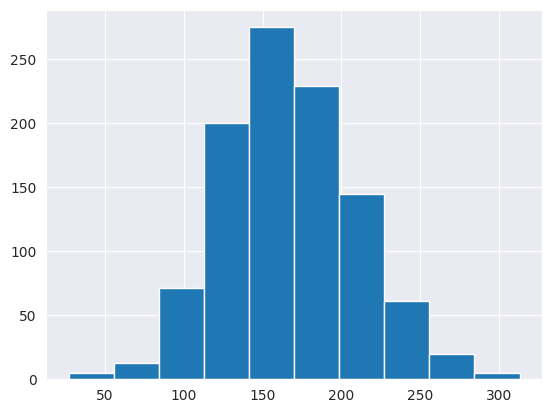

In [99]:
pd.plotting.hist_series(df['n_tokens_ans_200'])

<Axes: >

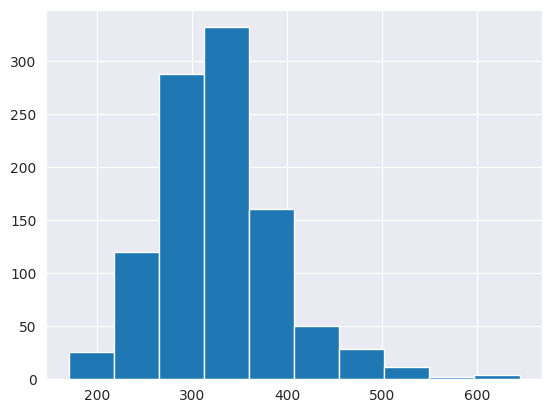

In [100]:
pd.plotting.hist_series(df['n_tokens_ans_600'])

In [18]:
df.to_excel(f'data/02_data_with_answers_with_tokens.xlsx')

### Verifing the quality of generated answers and questions based on selected metrics

#### Selected metrics
- Coverage 
- Coherence (Consistency)
- Word Mover Distance (Diversity)
- Relevance
- Global relevance

In [19]:
df['coverage_rating'] = df.apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_coverage(question=x['questions_splitted'], context=x['text_chunk'])), axis=1)

<Axes: >

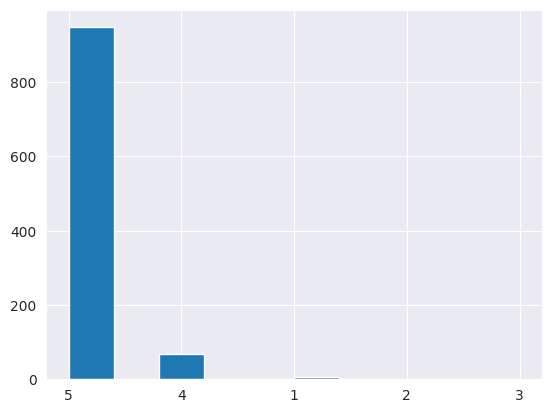

In [19]:
pd.plotting.hist_series(df['coverage_rating'])

In [20]:
df.to_excel(f'data/03_data_with_answers_and_cov.xlsx')

In [21]:
df['chunk'] = df['text_chunk'].apply(lambda x: clean_text(x))

In [22]:
dist_evaluator = DistanceEvaluator()
df['wmd_question_answer_600'] = df.apply(lambda x: dist_evaluator.get_diversity_by_wmd(x['questions_splitted'], x['answer']), axis=1)

In [23]:
df['wmd_question_answer_200'] = df.apply(lambda x: dist_evaluator.get_diversity_by_wmd(x['questions_splitted'], x['answer_200']), axis=1)

<Axes: >

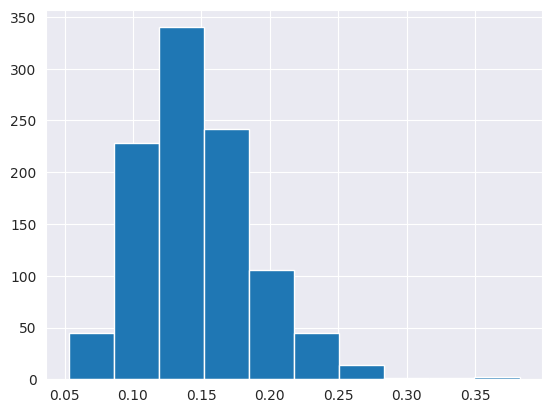

In [24]:
pd.plotting.hist_series(df['wmd_question_answer_600'])

<Axes: >

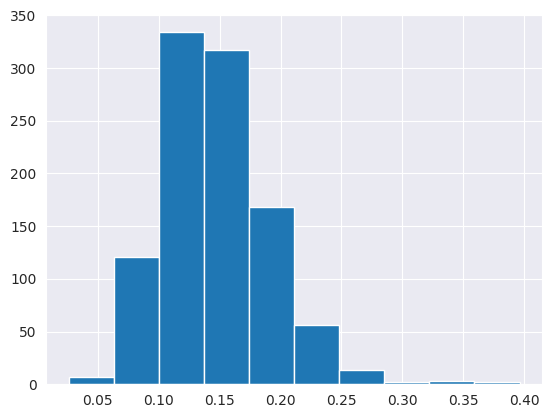

In [25]:
pd.plotting.hist_series(df['wmd_question_answer_200'])

In [26]:
df['wmd_chunk_question'] = df.apply(lambda x: dist_evaluator.get_diversity_by_wmd(x['text_chunk'], x['questions_splitted']), axis=1)

<Axes: >

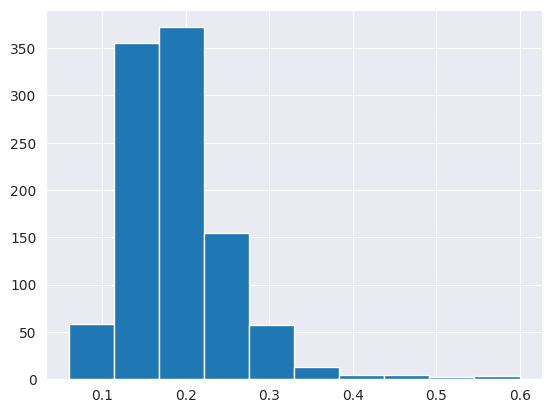

In [27]:
pd.plotting.hist_series(df['wmd_chunk_question'])

In [28]:
df['coherence'] = df['questions_splitted'].apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_coherence(x)))

In [29]:
df['coherence_pl'] = df['questions_splitted'].apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_coherence_pl(x)))

In [22]:
df.to_excel(f'data/05_data_with_coherence.xlsx')

In [23]:
df = pd.read_excel(f'data/05_data_with_coherence.xlsx', index_col=0)

In [30]:
df.columns

Index(['chunk_id', 'text_chunk', 'page_id', 'generated_questions',
       'questions_splitted', 'answer', 'answer_200', 'coverage_rating',
       'chunk', 'wmd_question_answer_600', 'wmd_question_answer_200',
       'wmd_chunk_question', 'coherence', 'coherence_pl'],
      dtype='object')

In [35]:
#df[['coherence_rate', 'coherence_expl']] = df.coherence.str.split(',', n=1,  expand=True)
df[['coherence_rate_pl', 'coherence_expl_pl']] = df.coherence_pl.str.split('|', n=1,  expand=True)


In [32]:
df['coherence_rate'] = df.coherence_rate.str.replace('(', '')
df['coherence_expl'] = df.coherence_expl.str.replace(')', '')
df['coherence_expl'] = df.coherence_expl.str.replace('"', '')

,chunk_id,text_chunk,page_id,generated_questions,questions_splitted,answer,answer_200,coverage_rating,chunk,wmd_question_answer_600,wmd_question_answer_200,wmd_chunk_question,coherence,coherence_pl,coherence_rate,coherence_expl,coherence_rate_pl,coherence_expl_pl
0,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90,- Jakie prawa określa ustawa z dnia 30 maja 20...,- Jakie prawa określa ustawa z dnia 30 maja 20...,Ustawa z dnia 30 maja 2014 r. o prawach konsum...,Ustawa z dnia 30 maja 2014 r. o prawach konsum...,5,©Kancelaria Sejmu s. 1/44 2024-01-18 D...,0.382522,0.323583,0.301395,"(3, ""The question is clear and specific, askin...","3 | Pytanie jest dość klarowne, ale mogłoby by...",3,"The question is clear and specific, asking ab...",3 | Pytanie jest dość klarowne,ale mogłoby być bardziej precyzyjne. Ustawa z...
0,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90,- Jakie prawa określa ustawa z dnia 30 maja 20...,- Jakie są obowiązki przedsiębiorcy zawierając...,"Zgodnie z art. 1 ustawy o prawach konsumenta, ...","Zgodnie z art. 1 ustawy o prawach konsumenta, ...",5,©Kancelaria Sejmu s. 1/44 2024-01-18 D...,0.168751,0.139664,0.236557,"(3, The question is coherent in terms of addre...","3 | Pytanie jest dość spójne, ponieważ jasno o...",3,The question is coherent in terms of addressi...,3 | Pytanie jest dość spójne,ponieważ jasno odnosi się do konkretnego arty...
0,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90,- Jakie prawa określa ustawa z dnia 30 maja 20...,- W jaki sposób regulowane są zasady i tryb za...,Zgodnie z Ustawą z dnia 30 maja 2014 r. o praw...,Zasady i tryb zawierania umowy na odległość i ...,5,©Kancelaria Sejmu s. 1/44 2024-01-18 D...,0.123767,0.108494,0.192996,"(4, ""The question is coherent and flows well, ...",5 | Pytanie jest bardzo spójne i precyzyjne. O...,4,"The question is coherent and flows well, but ...",5 | Pytanie jest bardzo spójne i precyzyjne. O...,na którym skupić się podczas udzielania odpow...
0,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90,- Jakie prawa określa ustawa z dnia 30 maja 20...,- Jakie są zasady i tryb wykonania prawa odstą...,Zgodnie z przepisami Ustawy o prawach konsumen...,Zgodnie z przepisami Ustawy o prawach konsumen...,5,©Kancelaria Sejmu s. 1/44 2024-01-18 D...,0.166820,0.189112,0.244153,"(3, The question is coherent in terms of askin...","4 | Pytanie jest spójne i precyzyjne, jasno ok...",3,The question is coherent in terms of asking a...,4 | Pytanie jest spójne i precyzyjne,jasno określa temat dotyczący prawa odstąpien...
1,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90_1,przedsiębiorstwa; \n3) \nzasady i tryb wykonan...,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90,- Jakie są zasady i tryb wykonania prawa odstą...,- Jakie są zasady i tryb wykonania prawa odstą...,"Zgodnie z przekazanym tekstem, zasady i tryb w...","Zgodnie z przekazanym tekstem, zasady i tryb w...",5,przedsiębiorstwa; 3) zasady i tryb wykonania p...,0.122753,0.121280,0.161208,"(3, ""The question is coherent in terms of lega...","4 | Pytanie jest spójne i precyzyjne, dotyczy ...",3,The question is coherent in terms of legal te...,4 | Pytanie jest spójne i precyzyjne,dotyczy konkretnego zagadnienia prawa odstąpi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,e30a4e6b-7f52-419e-8285-2fe7ef74a30b_0,©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n...,e30a4e6b-7f52-419e-8285-2fe7ef74a30b,- Czy formularz odstąpienia od umowy jest obow...,- Jakie są konsekwencje prawne odstąpienia od ...,Odstąpienie od umowy sprzedaży w Polsce ma okr...,Odstąpienie od umowy sprzedaży w Polsce ma swo...,5,©Kancelaria Sejmu s. 44/44 2024-01-18 Z...,0.164431,0.158811,0.273823,"(4, ""The question is coherent and cl

In [36]:
df

,chunk_id,text_chunk,page_id,generated_questions,questions_splitted,answer,answer_200,coverage_rating,chunk,wmd_question_answer_600,wmd_question_answer_200,wmd_chunk_question,coherence,coherence_pl,coherence_rate,coherence_expl,coherence_rate_pl,coherence_expl_pl
0,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90,- Jakie prawa określa ustawa z dnia 30 maja 20...,- Jakie prawa określa ustawa z dnia 30 maja 20...,Ustawa z dnia 30 maja 2014 r. o prawach konsum...,Ustawa z dnia 30 maja 2014 r. o prawach konsum...,5,©Kancelaria Sejmu s. 1/44 2024-01-18 D...,0.382522,0.323583,0.301395,"(3, ""The question is clear and specific, askin...","3 | Pytanie jest dość klarowne, ale mogłoby by...",3,"The question is clear and specific, asking ab...",3,"Pytanie jest dość klarowne, ale mogłoby być b..."
0,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90,- Jakie prawa określa ustawa z dnia 30 maja 20...,- Jakie są obowiązki przedsiębiorcy zawierając...,"Zgodnie z art. 1 ustawy o prawach konsumenta, ...","Zgodnie z art. 1 ustawy o prawach konsumenta, ...",5,©Kancelaria Sejmu s. 1/44 2024-01-18 D...,0.168751,0.139664,0.236557,"(3, The question is coherent in terms of addre...","3 | Pytanie jest dość spójne, ponieważ jasno o...",3,The question is coherent in terms of addressi...,3,"Pytanie jest dość spójne, ponieważ jasno odno..."
0,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90,- Jakie prawa określa ustawa z dnia 30 maja 20...,- W jaki sposób regulowane są zasady i tryb za...,Zgodnie z Ustawą z dnia 30 maja 2014 r. o praw...,Zasady i tryb zawierania umowy na odległość i ...,5,©Kancelaria Sejmu s. 1/44 2024-01-18 D...,0.123767,0.108494,0.192996,"(4, ""The question is coherent and flows well, ...",5 | Pytanie jest bardzo spójne i precyzyjne. O...,4,"The question is coherent and flows well, but ...",5,Pytanie jest bardzo spójne i precyzyjne. Okre...
0,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90_0,©Kancelaria Sejmu \n \n \n \ns. 1/44 \n \n \n ...,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90,- Jakie prawa określa ustawa z dnia 30 maja 20...,- Jakie są zasady i tryb wykonania prawa odstą...,Zgodnie z przepisami Ustawy o prawach konsumen...,Zgodnie z przepisami Ustawy o prawach konsumen...,5,©Kancelaria Sejmu s. 1/44 2024-01-18 D...,0.166820,0.189112,0.244153,"(3, The question is coherent in terms of askin...","4 | Pytanie jest spójne i precyzyjne, jasno ok...",3,The question is coherent in terms of asking a...,4,"Pytanie jest spójne i precyzyjne, jasno okreś..."
1,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90_1,przedsiębiorstwa; \n3) \nzasady i tryb wykonan...,c2a0fa0c-cfd1-42e8-b303-1c2f7a6f0d90,- Jakie są zasady i tryb wykonania prawa odstą...,- Jakie są zasady i tryb wykonania prawa odstą...,"Zgodnie z przekazanym tekstem, zasady i tryb w...","Zgodnie z przekazanym tekstem, zasady i tryb w...",5,przedsiębiorstwa; 3) zasady i tryb wykonania p...,0.122753,0.121280,0.161208,"(3, ""The question is coherent in terms of lega...","4 | Pytanie jest spójne i precyzyjne, dotyczy ...",3,The question is coherent in terms of legal te...,4,"Pytanie jest spójne i precyzyjne, dotyczy kon..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,e30a4e6b-7f52-419e-8285-2fe7ef74a30b_0,©Kancelaria Sejmu \n \n \n \ns. 44/44 \n \n \n...,e30a4e6b-7f52-419e-8285-2fe7ef74a30b,- Czy formularz odstąpienia od umowy jest obow...,- Jakie są konsekwencje prawne odstąpienia od ...,Odstąpienie od umowy sprzedaży w Polsce ma okr...,Odstąpienie od umowy sprzedaży w Polsce ma swo...,5,©Kancelaria Sejmu s. 44/44 2024-01-18 Z...,0.164431,0.158811,0.273823,"(4, ""The question is coherent and clear, askin...","4 | Pytanie jest spójne, ponieważ precyzyjnie ...",4,"The question is coherent and clear, asking ab...",4,"Pytanie jest spójne, ponieważ precyzyjnie o

In [37]:
df.to_excel(f'data/06_data_with_expanded_coherence.xlsx', index = False)

In [28]:
df = pd.read_excel(f'data/06_data_with_expanded_coherence.xlsx')

In [29]:
df.columns

Index(['chunk_id', 'text_chunk', 'page_id', 'generated_questions',
       'questions_splitted', 'answer', 'coverage_rating', 'coherence',
       'coherence_rate', 'coherence_expl'],
      dtype='object')

In [38]:
df['relevance'] = df.apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_relevance(question=x['questions_splitted'], context=x['text_chunk'])),axis=1)

In [39]:
df['global_relevance'] = df.apply(lambda x: OpenAIReq().call_api(prompt=PromptBuilder.get_global_relevance(question=x['questions_splitted'])),axis=1)

In [41]:
df.to_excel(f'data/07_data_with_relevances.xlsx')

## Evaluation

In [42]:
reporting = Reporting(data=df)
sim_matrix = reporting.create_similarity_matrix_for_wmd(on_column='questions_splitted')

1024it [14:13,  1.20it/s]


In [35]:
sim_matrix.shape

(1024, 1024)

### Plotting the results of similarity matrix

In [43]:
if sim_matrix.shape[0] < 30: #plot only when sampled
    mask = np.zeros_like(sim_matrix)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(sim_matrix,
                annot=True,
                fmt='.2f',
                linewidth=.5,
                cmap='crest',
                mask=mask,
                annot_kws={'fontsize': 8})

### Evaluation Summary

#### Relevance anf global relevance

In [44]:
df['relevance'].value_counts(normalize=True)

relevance
5    0.992188
4    0.003906
1    0.002930
3    0.000977
Name: proportion, dtype: float64

<Axes: >

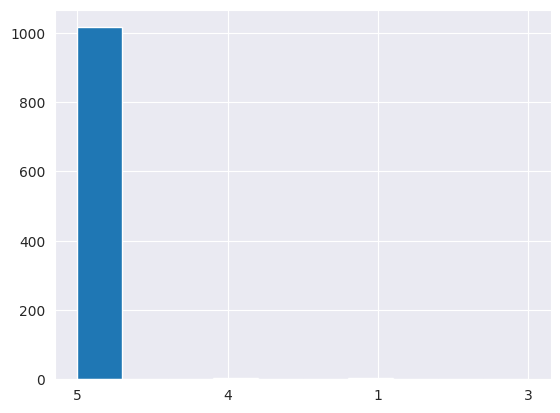

In [45]:
pd.plotting.hist_series(df['relevance'])

In [46]:
df['global_relevance'].value_counts(normalize=True)

global_relevance
5    0.993164
1    0.003906
4    0.000977
3    0.000977
2    0.000977
Name: proportion, dtype: float64

<Axes: >

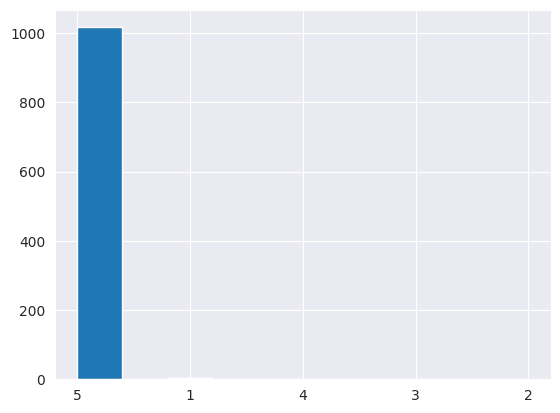

In [47]:
pd.plotting.hist_series(df['global_relevance'])

#### Coverage summary

In [48]:
df['coverage_rating'].value_counts(normalize=True)

coverage_rating
5    0.927734
4    0.065430
1    0.006836
Name: proportion, dtype: float64

<Axes: >

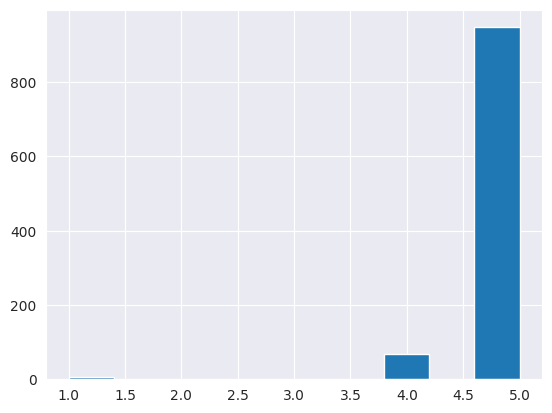

In [41]:
pd.plotting.hist_series(df['coverage_rating'])

In [52]:
df.columns

Index(['chunk_id', 'text_chunk', 'page_id', 'generated_questions',
       'questions_splitted', 'answer', 'answer_200', 'coverage_rating',
       'chunk', 'wmd_question_answer_600', 'wmd_question_answer_200',
       'wmd_chunk_question', 'coherence', 'coherence_pl', 'coherence_rate',
       'coherence_expl', 'coherence_rate_pl', 'coherence_expl_pl', 'relevance',
       'global_relevance'],
      dtype='object')

#### Word mover distance

<Axes: >

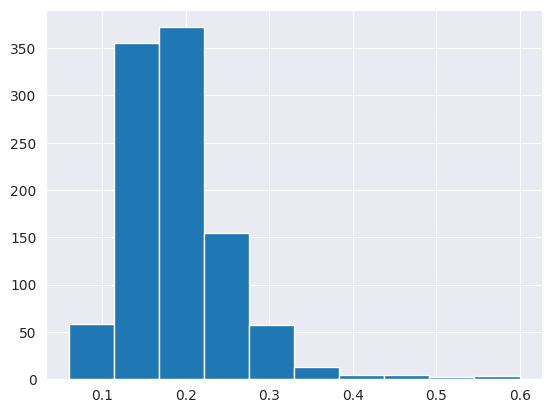

In [49]:
# WMD question <-> chunk
pd.plotting.hist_series(df['wmd_chunk_question'])

In [50]:
mean_wmd_qch = df['wmd_chunk_question'].mean()
std_wmd_qch = df['wmd_chunk_question'].std()
print(f'Mean for question to chunk for WMD is {mean_wmd_qch} with std as {std_wmd_qch}')

Mean for question to chunk for WMD is 0.18992659685328583 with std as 0.06288713143204415


<Axes: >

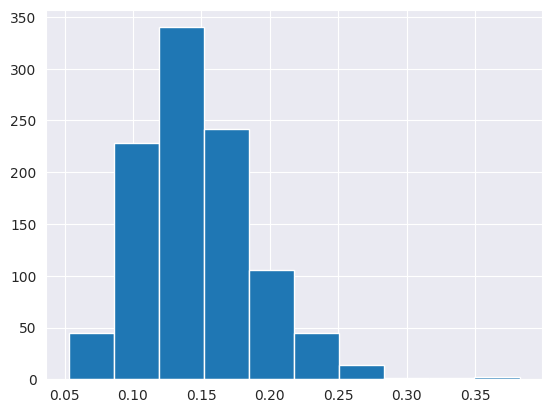

In [53]:
# WMD question <-> answer
pd.plotting.hist_series(df['wmd_question_answer_600'])

In [55]:
mean_wmd_qa = df['wmd_question_answer_600'].mean()
std_wmd_qa = df['wmd_question_answer_600'].std()
print(f'Mean for question to answer for WMD is {mean_wmd_qa} with std as {std_wmd_qa}')

Mean for question to answer for WMD is 0.14661725889211422 with std as 0.04155135223607651


<Axes: >

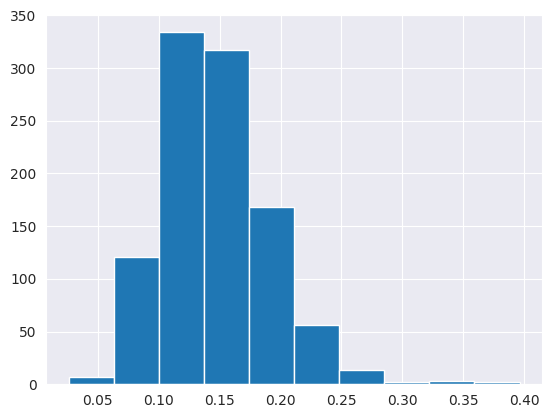

In [56]:
# WMD question <-> answer
pd.plotting.hist_series(df['wmd_question_answer_200'])

In [57]:
mean_wmd_qa = df['wmd_question_answer_200'].mean()
std_wmd_qa = df['wmd_question_answer_200'].std()
print(f'Mean for question to answer for WMD is {mean_wmd_qa} with std as {std_wmd_qa}')

Mean for question to answer for WMD is 0.1465598756315475 with std as 0.04386092516847709


In [58]:
# WMD question <-> question
std, mean = reporting.get_summary_for_wmd(sim_matrix)
print(f'Mean for question to question for WMD is {mean} with std as {std}')

Mean for question to question for WMD is 0.2319945366162956 with std as 0.058350289261069374


#### Coherence rate

In [59]:
df['coherence_rate'].value_counts(normalize=True)

coherence_rate
3                                                                                                                                                                                                                                                                                0.454102
4                                                                                                                                                                                                                                                                                0.404297
2                                                                                                                                                                                                                                                                                0.130859
3 | The question is coherent in terms of legal terminology and structure                                                                   

In [77]:
coherence_analysis = df[['questions_splitted','coherence_expl_pl', 'coherence_rate_pl']]

In [78]:
coherence_analysis['coherence_rate_pl'] = coherence_analysis['coherence_rate_pl'].astype(int)

/tmp/ipykernel_65673/3825678281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coherence_analysis['coherence_rate_pl'] = coherence_analysis['coherence_rate_pl'].astype(int)


In [101]:
coherence_analysis[coherence_analysis['coherence_rate_pl'] == 2]

,questions_splitted,coherence_expl_pl,coherence_rate_pl
3,- Jakie konkretnie przepisy dotyczące sprzedaż...,Pytanie o zmiany w przepisach dotyczących spr...,2
31,- Jakie są konsekwencje prawne dotyczące umów ...,Pytanie o konsekwencje prawne dotyczące umów ...,2
143,- Czy istnieją jakieś wyjątki od obowiązku okr...,Pytanie jest dość skomplikowane i trudne do z...,2
209,- Kiedy domniemania określone w ust. 1 i 3 nie...,Pytanie jest dość skomplikowane i wymaga pewn...,2
209,- Jakie warunki musi spełniać środowisko cyfro...,Pytanie jest dość skomplikowane i wymaga głęb...,2


In [87]:
coherence_analysis['coherence_expl_pl']

0       Pytanie jest dość klarowne, ale mogłoby być b...
0       Pytanie jest dość spójne, ponieważ jasno odno...
0       Pytanie jest bardzo spójne i precyzyjne. Okre...
0       Pytanie jest spójne i precyzyjne, jasno okreś...
1       Pytanie jest spójne i precyzyjne, dotyczy kon...
                             ...                        
254     Pytanie jest spójne, ponieważ precyzyjnie okr...
255     Pytanie jest spójne, ponieważ precyzyjnie okr...
255     Pytanie jest spójne, ponieważ precyzyjnie okr...
255     Pytanie jest spójne i precyzyjne, dotyczy ter...
255     Pytanie jest spójne, ponieważ jasno określa, ...
Name: coherence_expl_pl, Length: 1024, dtype: object

#### Evaluation Summary
From the provided results we can observe that in majority of cases generated question are quite fluent (86.5% got score 3 and 4 combined).
Coverage metric (if answer can be reliable extracted from question and context) is also high. This point is to be investigated as it was based on LLM verification.
Relevance ratings are also high meaning that generated questions preserve high quality and resemblance to ones asked by professionals.
Word's Mover Distance (Diversity) with mean scores 0.19, 0.14 and 0.24 for question to chunk, question to answer and question to question respectively, show that generated questions have small distance which means that they show small diversity and are consistent with each other. 

In [92]:
df.columns

Index(['chunk_id', 'text_chunk', 'page_id', 'generated_questions',
       'questions_splitted', 'answer', 'answer_200', 'coverage_rating',
       'chunk', 'wmd_question_answer_600', 'wmd_question_answer_200',
       'wmd_chunk_question', 'coherence', 'coherence_pl', 'coherence_rate',
       'coherence_expl', 'coherence_rate_pl', 'coherence_expl_pl', 'relevance',
       'global_relevance'],
      dtype='object')

### Data preparation for FT

In [93]:
qa_df_200 = df[['questions_splitted', 'answer_200']]

In [94]:
qa_df_200

,questions_splitted,answer_200
0,- Jakie prawa określa ustawa z dnia 30 maja 20...,Ustawa z dnia 30 maja 2014 r. o prawach konsum...
0,- Jakie są obowiązki przedsiębiorcy zawierając...,"Zgodnie z art. 1 ustawy o prawach konsumenta, ..."
0,- W jaki sposób regulowane są zasady i tryb za...,Zasady i tryb zawierania umowy na odległość i ...
0,- Jakie są zasady i tryb wykonania prawa odstą...,Zgodnie z przepisami Ustawy o prawach konsumen...
1,- Jakie są zasady i tryb wykonania prawa odstą...,"Zgodnie z przekazanym tekstem, zasady i tryb w..."
...,...,...
254,- Jakie są konsekwencje prawne odstąpienia od ...,Odstąpienie od umowy sprzedaży w Polsce ma swo...
255,- Czy formularz odstąpienia od umowy sprzedaży...,"Tak, formularz odstąpienia od umowy sprzedaży ..."
255,- Jakie są konsekwencje odstąpienia od umowy s...,Odstąpienie od umowy sprzedaży w Polsce zgodni...
255,"- Czy istnieją określone terminy, w jakich kon...","W polskim prawie istnieją określone terminy, w..."


In [95]:
qa_df_200 = qa_df_200.rename(columns={'questions_splitted': 'question', 'answer_200': 'answer'})

In [96]:
now = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
with open(f'ft_output_data/data_ft_{now}.jsonl', "w") as f:
    f.write(qa_df_200.to_json(orient='records', lines=True, force_ascii=False))